# Capstone Project week2 - The Restaurant Battle of Neighborhoods IBM certification

Applied data Science Capstone Project - Final assignment


# Exploring venues in Pune, India 

# Table of contents :
     
    1.Introduction/Business problem 
    2.Data Collection from APIs 
    3.Data Cleaning 
    4.Methodolgy 
    5.Analysis 
    6.Results  
    7.Conclusion

# 1.Introduction/Business problem
 
Pune is Known as Cultural capital of Maharashtra as well as Oxford of east so it attracts lots of tourist and students.
Whenever a visitor is visiting a city they start looking for places to visit during their stay. The aim of the project is to help them find afordable, best venues in pune with help of average price and ratings. 
In this notebook, we will identify various venues in the city of Pune using Foursquare API and Zomato API, and data sceinece.
Total area of Pune 331.3 km²

# 2.Data Collection

We will fetch data using the two different APIs as-
Foursquare API-
    We will fecth venue data within 4 km starting from center of pune in each diection.
Zomato API-
    The Zomato API provides information about various venues including the complete address, user ratings, price for two people, price range and a lot more.
We will provide latitude and longitude values of Pune here.

In [1]:
#I First we will import required libraries


import numpy as np
import pandas as pd
import json
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
!pip install folium
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.io.json import json_normalize
from sklearn.metrics import silhouette_score

%matplotlib notebook

print('All libraries imported.')

     |████████████████████████████████| 94 kB 4.9 MB/s  eta 0:00:01
All libraries imported.


In [2]:
#Latitude longitude of Pune
pune_LATITUDE = 18.516726
pune_LONGITUDE = 73.856255
print('The geograpical coordinates of Pune are {}, {}.'.format(pune_LATITUDE, pune_LONGITUDE))

The geograpical coordinates of Pune are 18.516726, 73.856255.


# Creating map for Pune city with folium map

In [3]:
pune_map = folium.Map(location = [pune_LATITUDE, pune_LONGITUDE], zoom_start = 13)
folium.Marker([pune_LATITUDE, pune_LONGITUDE],popup='Pune').add_to(pune_map)
pune_map

## Foursquare API Credentials

In [4]:

CLIENT_ID = 'BOPSL53N4SKSKGVMBKXY4VZED0RC5UHHSLBN3UJDKX10C1HS' # your Foursquare ID
CLIENT_SECRET = '43IEGZG3TYA5UCEVTSLXTM1FNACSYI55NZRERVK2FABW0GKI' # your Foursquare Secret
VERSION = '20210205' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value #no of venues
RADIUS=4000 #4k
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: BOPSL53N4SKSKGVMBKXY4VZED0RC5UHHSLBN3UJDKX10C1HS
CLIENT_SECRET:43IEGZG3TYA5UCEVTSLXTM1FNACSYI55NZRERVK2FABW0GKI


# We define the get_category_type method to get the correct category for each venue

In [5]:

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#The maximum venues this API can fetch is 100, so we will fetch all venues by iteratively calling this API and increasing the offset each time.
#Foursquare API requires client_id, and client_secret to function which can be accessed after creating a developer account.

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
offset = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(CLIENT_ID, 
                                                                        CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        pune_LATITUDE, 
                                                                        pune_LONGITUDE, 
                                                                        RADIUS,
                                                                        LIMIT,
                                                                        offset)
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, RADIUS/1000))

    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)

    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

foursquare_venues = foursquare_venues.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))

Total 100 venues fetched within a total radius of 4.0 Km


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:23: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


Total 100 venues fetched within a total radius of 4.0 Km
Total 12 venues fetched within a total radius of 4.0 Km

Total 212 venues fetched


# Zomato API
Zomato requires a Zomato user key which can be accessed with a developer account.

We'll use the name, lat, and lang values of various venues fetched from Foursquare API to use the search API and get more information regarding each venue.
Here-
Query-name of the venue.
Start- from which offset we want to start, so we'll keep it at 0.
Count-the number of restaurants we want to fetch. As we have the exact location coordinates, we'll fetch only one.
We will supply the latitude and longitude values.
We will set the sorting criteria as real_distance so each time we get the venue we're searching based on location coordinates.

In [7]:
headers = {'user-key': '6961ea1b710b9dd6f3f2718d1fc38e0f'}
venues_information = []

for index, row in foursquare_venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6))
    
zomato_venues = pd.DataFrame(venues_information,columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29
Fetching data for venue: 30
Fetching data for venue: 31
Fetching data for venue: 32
Fetching data for venue: 33
Fetching data for venue: 34
Fetching data for venue: 35
Fetching data for venue: 36
F

In [8]:
zomato_venues

,venue,latitude,longitude,price_for_two,price_range,rating,address
0,Sujata Mastani,18.5117393788,73.8521783799,200.0,1.0,4.5,"Survey 1260, Nimbalkar Talim Chowk, Sadashiv P..."
1,Hotel Marathwada,18.5160491630,73.8478285074,350.0,1.0,3.2,"Kelkar Road, Near Narayan Peth Police Station,..."
2,Bapat Veg Uphar Gruh,18.5105363332,73.8542168587,400.0,1.0,3.6,"Shop 2 & 3, 1376, Bajirao Road, Near Kelkar Mu..."
3,Mahesh Lunch Home,18.5205324187,73.8724072650,1500.0,3.0,4.0,"Shop 18, Ashoka Pavillion, Near Lal Deval, Amb..."
4,CAFE PETER,18.5204392704,73.8437897712,900.0,2.0,4.1,"Survey 1206/B, Apte Road, Shivaji Nagar, Pune"
5,J J Pure Veg Manchurian,18.5442190000,73.8727810000,200.0,1.0,0,"Prabhak 6, Jay Jawan Nagar, Bhagat Singh Chowk..."
6,Hotel Tilak,18.5095876253,73.8469517604,350.0,1.0,4.2,"1549, Indira Chambers, Opposite Maharashtra Ma..."
7,Cafe Goodluck,18.5174438744,73.8414964825,800.0,2.0,4.3,"759/75, Goodluck Chowk, Deccan Gymkhana, Pune"
8,Barbeque Nation,18.5162720251,73.8424104452,1700.0,3.0,4.3,"3rd Floor, R Deccan Mall, JM Road, Pune"
9,Shree Krishna Juice Bar,18.5235357083,73.8476622105,150.0,1.0,4.0,"Plot 1187/27, Bhagirathi Building, Near Federa..."


# 3.Data Cleaning
We retrived the data from multiple resources and data might not always align hence it is important to combine the data properly.
Data should be unique hence need to clean duplicate redundant,wrong data.We should remove the mismatched data

In [8]:
#Plot Foursquare data on map
pune_map= folium.Map(location = [pune_LATITUDE, pune_LONGITUDE], zoom_start = 13)

for name, latitude, longitude in zip(foursquare_venues['name'], foursquare_venues['lat'], foursquare_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(pune_map)  

pune_map

From map we can see their are clusters of venues infer near deccan and camp area of Pune

In [9]:
#zomato  data on map
pune_map = folium.Map(location = [pune_LATITUDE, pune_LONGITUDE], zoom_start = 13)

for venue, address, latitude, longitude in zip(zomato_venues['venue'], zomato_venues['address'], 
                                               zomato_venues['latitude'], zomato_venues['longitude']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cc3535',
        fill_opacity = 0.7,
        parse_html = False).add_to(pune_map)  
pune_map


#As we can see that there are so many venues identified by both Foursquare and Zomato. There is a lot of overlapping at deccan gymkhana,Cantonment area
#some data does not match just like the red dots in the bottom  on the second map.

In [10]:
#Lets combine two dataset and check wether latitude and longitude values for each corrospondent venue is similar or not and need to check wether two locations are same or differnet
foursquare_venues['lat'] = foursquare_venues['lat'].apply(lambda lat: round(float(lat), 4))
foursquare_venues['lng'] = foursquare_venues['lng'].apply(lambda lng: round(float(lng), 4))
zomato_venues['latitude'] = zomato_venues['latitude'].apply(lambda lat: round(float(lat), 4))#consider lat long upto 4 decimal places
zomato_venues['longitude'] = zomato_venues['longitude'].apply(lambda lng: round(float(lng), 4))

In [11]:
dataset = pd.concat([foursquare_venues, zomato_venues], axis = 1)
dataset['lat_diff'] = dataset['latitude'] - dataset['lat'] #if diff is < 0.0004 means same location 
dataset['lng_diff'] = dataset['longitude'] - dataset['lng']

In [12]:
venues_selected = dataset[(abs(dataset['lat_diff']) <= 0.0004) & (abs(dataset['lng_diff']) <= 0.0004)].reset_index(drop = True)
venues_selected

,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,Sujata Mastani,Ice Cream Shop,18.5118,73.8521,Sujata Mastani,18.5117,73.8522,200.0,1.0,4.5,"Survey 1260, Nimbalkar Talim Chowk, Sadashiv P...",-0.0001,0.0001
1,Raja Dinkar Kelkar museum,History Museum,18.5107,73.8544,Bapat Veg Uphar Gruh,18.5105,73.8542,400.0,1.0,3.6,"Shop 2 & 3, 1376, Bajirao Road, Near Kelkar Mu...",-0.0002,-0.0002
2,Tilak Hotel,Snack Place,18.5096,73.8469,Hotel Tilak,18.5096,73.8470,350.0,1.0,4.2,"1549, Indira Chambers, Opposite Maharashtra Ma...",0.0000,0.0001
3,Café GoodLuck,Café,18.5174,73.8415,Cafe Goodluck,18.5174,73.8415,800.0,2.0,4.3,"759/75, Goodluck Chowk, Deccan Gymkhana, Pune",0.0000,0.0000
4,Barbeque Nation,BBQ Joint,18.5162,73.8422,Barbeque Nation,18.5163,73.8424,1700.0,3.0,4.3,"3rd Floor, R Deccan Mall, JM Road, Pune",0.0001,0.0002
5,Krishna Juice Bar,Juice Bar,18.5236,73.8477,Shree Krishna Juice Bar,18.5235,73.8477,150.0,1.0,4.0,"Plot 1187/27, Bhagirathi Building, Near Federa...",-0.0001,0.0000
6,Hotel Roopali,Indian Restaurant,18.5193,73.8413,Roopali Restaurant,18.5195,73.8414,400.0,1.0,4.3,"1227, Opposite British Library, FC Road, Pune",0.0002,0.0001
7,Le Plaisir,Bistro,18.5142,73.8386,Le Plaisir,18.5143,73.8386,1000.0,3.0,4.6,"Survey 759/125, Rajkamal, Opposite Kelkar Eye ...",0.0001,0.0000
8,Vaishali | वैशाली,South Indian Restaurant,18.5209,73.8413,Vaishali,18.5210,73.8412,500.0,2.0,4.5,"1218/1, Rage Path, Ganeshwadi, Shivajinagar, F...",0.0001,-0.0001
9,Sukanta,Vegetarian / Vegan Restaurant,18.5169,73.8443,Sukanta,18.5171,73.8443,700.0,2.0,4.4,"636, Pulachi Wadi, Deccan Gymkhana, Pune",0.0002,0.0000


In [13]:
venues_selected.shape

(136, 13)

In [14]:
venues_selected


,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,Sujata Mastani,Ice Cream Shop,18.5118,73.8521,Sujata Mastani,18.5117,73.8522,200.0,1.0,4.5,"Survey 1260, Nimbalkar Talim Chowk, Sadashiv P...",-0.0001,0.0001
1,Raja Dinkar Kelkar museum,History Museum,18.5107,73.8544,Bapat Veg Uphar Gruh,18.5105,73.8542,400.0,1.0,3.6,"Shop 2 & 3, 1376, Bajirao Road, Near Kelkar Mu...",-0.0002,-0.0002
2,Tilak Hotel,Snack Place,18.5096,73.8469,Hotel Tilak,18.5096,73.8470,350.0,1.0,4.2,"1549, Indira Chambers, Opposite Maharashtra Ma...",0.0000,0.0001
3,Café GoodLuck,Café,18.5174,73.8415,Cafe Goodluck,18.5174,73.8415,800.0,2.0,4.3,"759/75, Goodluck Chowk, Deccan Gymkhana, Pune",0.0000,0.0000
4,Barbeque Nation,BBQ Joint,18.5162,73.8422,Barbeque Nation,18.5163,73.8424,1700.0,3.0,4.3,"3rd Floor, R Deccan Mall, JM Road, Pune",0.0001,0.0002
5,Krishna Juice Bar,Juice Bar,18.5236,73.8477,Shree Krishna Juice Bar,18.5235,73.8477,150.0,1.0,4.0,"Plot 1187/27, Bhagirathi Building, Near Federa...",-0.0001,0.0000
6,Hotel Roopali,Indian Restaurant,18.5193,73.8413,Roopali Restaurant,18.5195,73.8414,400.0,1.0,4.3,"1227, Opposite British Library, FC Road, Pune",0.0002,0.0001
7,Le Plaisir,Bistro,18.5142,73.8386,Le Plaisir,18.5143,73.8386,1000.0,3.0,4.6,"Survey 759/125, Rajkamal, Opposite Kelkar Eye ...",0.0001,0.0000
8,Vaishali | वैशाली,South Indian Restaurant,18.5209,73.8413,Vaishali,18.5210,73.8412,500.0,2.0,4.5,"1218/1, Rage Path, Ganeshwadi, Shivajinagar, F...",0.0001,-0.0001
9,Sukanta,Vegetarian / Vegan Restaurant,18.5169,73.8443,Sukanta,18.5171,73.8443,700.0,2.0,4.4,"636, Pulachi Wadi, Deccan Gymkhana, Pune",0.0002,0.0000


In [15]:
venues_selected = venues_selected.drop([0,1,5,11,14,15,21,25,29,34,50,74,81,94,96,97,105,111,116,127]).reset_index(drop = True)

In [16]:
venues_selected.shape

(116, 13)

In [17]:
#Drop some columns

venues_selected['average_price'] = venues_selected['price_for_two']/2
venues_selected = venues_selected.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff', 'price_for_two'])

In [18]:
venues_selected.head()

,categories,venue,latitude,longitude,price_range,rating,address,average_price
0,Snack Place,Hotel Tilak,18.5096,73.8470,1.0,4.2,"1549, Indira Chambers, Opposite Maharashtra Ma...",175.0
1,Café,Cafe Goodluck,18.5174,73.8415,2.0,4.3,"759/75, Goodluck Chowk, Deccan Gymkhana, Pune",400.0
2,BBQ Joint,Barbeque Nation,18.5163,73.8424,3.0,4.3,"3rd Floor, R Deccan Mall, JM Road, Pune",850.0
3,Indian Restaurant,Roopali Restaurant,18.5195,73.8414,1.0,4.3,"1227, Opposite British Library, FC Road, Pune",200.0
4,Bistro,Le Plaisir,18.5143,73.8386,3.0,4.6,"Survey 759/125, Rajkamal, Opposite Kelkar Eye ...",500.0


In [19]:
#Drop all rating which are 0.0 that means not rated yet
venues_selected = venues_selected[venues_selected['rating'] != 0.0]
print("Total venues available: {}".format(venues_selected.shape[0]))


Total venues available: 109


In [20]:
venues_selected.head()

,categories,venue,latitude,longitude,price_range,rating,address,average_price
0,Snack Place,Hotel Tilak,18.5096,73.8470,1.0,4.2,"1549, Indira Chambers, Opposite Maharashtra Ma...",175.0
1,Café,Cafe Goodluck,18.5174,73.8415,2.0,4.3,"759/75, Goodluck Chowk, Deccan Gymkhana, Pune",400.0
2,BBQ Joint,Barbeque Nation,18.5163,73.8424,3.0,4.3,"3rd Floor, R Deccan Mall, JM Road, Pune",850.0
3,Indian Restaurant,Roopali Restaurant,18.5195,73.8414,1.0,4.3,"1227, Opposite British Library, FC Road, Pune",200.0
4,Bistro,Le Plaisir,18.5143,73.8386,3.0,4.6,"Survey 759/125, Rajkamal, Opposite Kelkar Eye ...",500.0


# 4.Methodology

This project aims at identifying the venues in Pune based on their rating and average costs.This would enable any visitor to identify the venues they  wants to visit based on their rating and cost preference.

* First we retrieved the data from two APIs Foursquare and Zomato. We extracted venue information from the center of Pune, upto a distance of 4 Km.in each direction.
The latitude and longitude values are then used to fetch venue rating and price from Zomato.
* Then we explored the data retrieved from the two APIs on the map and identified the top category types. The data from the two sources are carefully combined based on the name, latitude and longitude values from the two sources. The final dataset would include the rating and price values for each venue
*Next, we will analyse the data that we created based on the ratings and price of each venue. We will identify places where many venues are located so that any visitor can go to the place and enjoy the option to choose amongst many venue options. We will also explore areas that are high rated and those that are low rated while also plot the map of high and low priced venues. Lastly, we will cluster the venues based on the available information of each venue. This will allow us to clearly identify which venues can be recommended and with what characteristics.

Finally, we will discuss and conclude which venues to be explored based on visitor requirement of rating and cost.

# 5.Data Analysis

We will inspect these venues based on their rating. The rating of a venue are based on user reviews and ranged from 1 to 5. We will also analyse the venues based on their price per person(Average cost) as well as the price range.

<IPython.core.display.Javascript object>


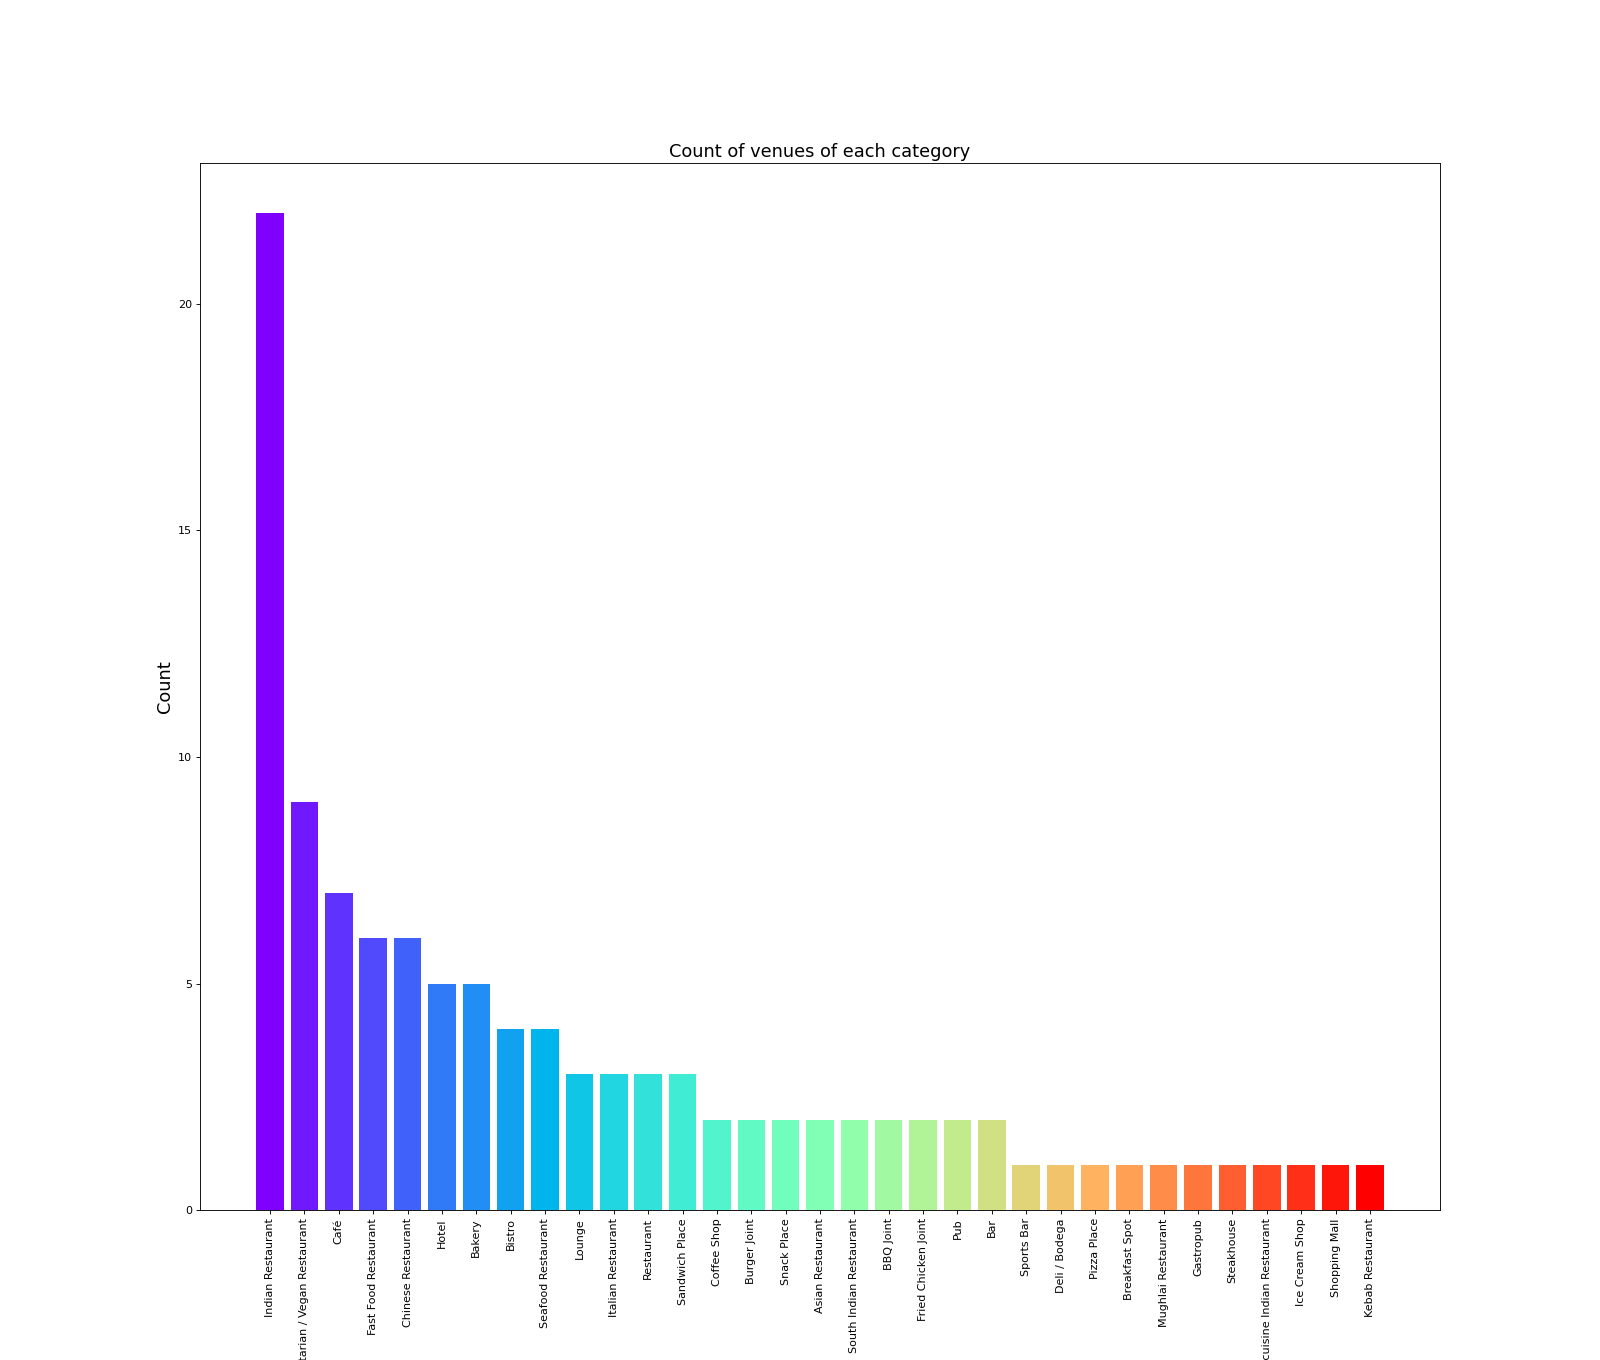

<BarContainer object of 33 artists>

In [21]:
venue_distribution = venues_selected['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (20, 17))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

As we can see the majority venues are Indian Restaurant and vegan/vegitarian restaurants. So, if you are tourist and want to try authentic food culture of pune you can try these.

# Rating vs Count of venue

With help of Rating of a venue visitor decides whether it is worth it to visit the place. But For that we need to see what is the average rating for all the venues in the city. we will plot the venues on the map and use different colors to distinguish them
We will first identify the various rating values and plot them as a bar plot with their counts to see the most common rating

<IPython.core.display.Javascript object>


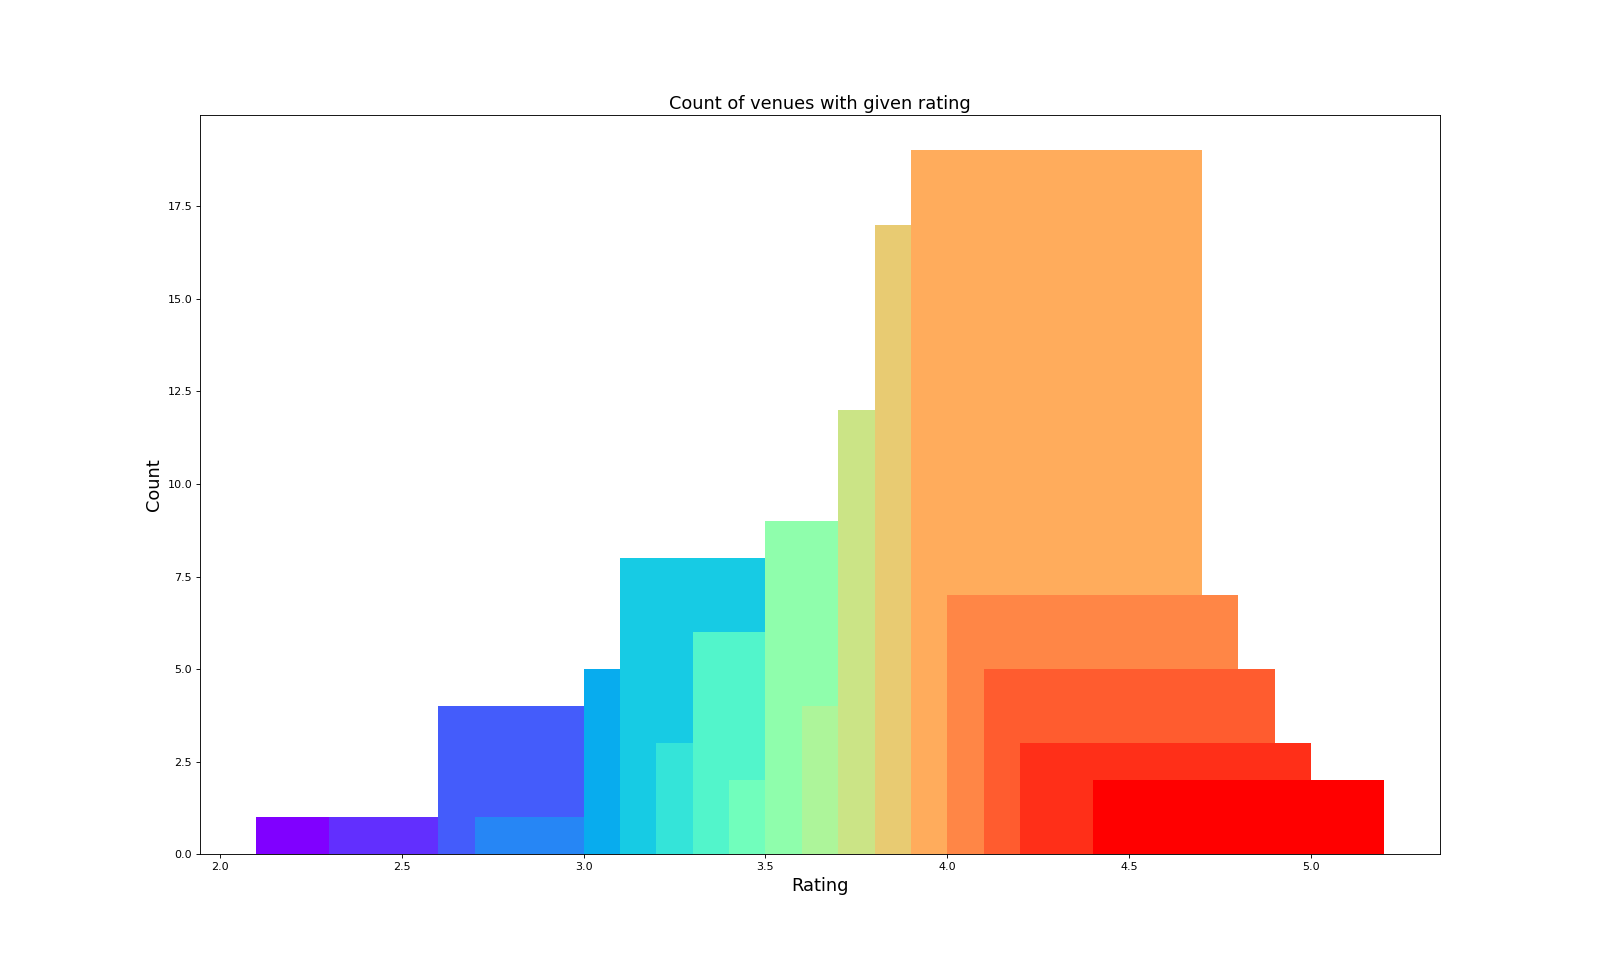

Text(0.5, 1.0, 'Count of venues with given rating')

In [22]:
venues_selected['rating'] = venues_selected['rating'].astype(float)
rating =venues_selected['rating'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)

From the plot above, it is clear that majority venues have their rating close to 4.

Let's create bins for various ratings and plot them in different colors on the map. The ratings will be divided between 4 bins:

*1 to 2
*2 to 3
*3 to 4
*4 to 5

In [23]:
bins = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Low', 'Okay', 'Good', 'Very good']
venues_selected['rating_bin'] = pd.cut(venues_selected['rating'].astype(float), bins = bins, labels = labels, include_lowest = True)

#plot venues on the map

In [24]:
color_map = {'Low': 'red', 'Okay': 'orange', 'Good': 'blue', 'Very good': 'darkgreen'}

pune_map = folium.Map(location = [pune_LATITUDE, pune_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, rating_bin in zip(venues_selected['venue'], 
                                                          venues_selected['address'], 
                                                          venues_selected['latitude'], 
                                                          venues_selected['longitude'], 
                                                          venues_selected['rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(pune_map)  

pune_map

 The map has the location of all the venues. It appears that many venues are located near Deccan,Bundgarden camp area with rating above 3.If someone wants to explore new venues, they should definitely check out here

# Price vs Venue
We have two price features for our venues, one is average_price which defines the average cost for one person and the other is price_range which determines the price range as defined by Zomato.
We will first explore the average_price using a scatter plot between the price and the count of venues with that average price. We will display the points based on the price to highlight their price.

<IPython.core.display.Javascript object>


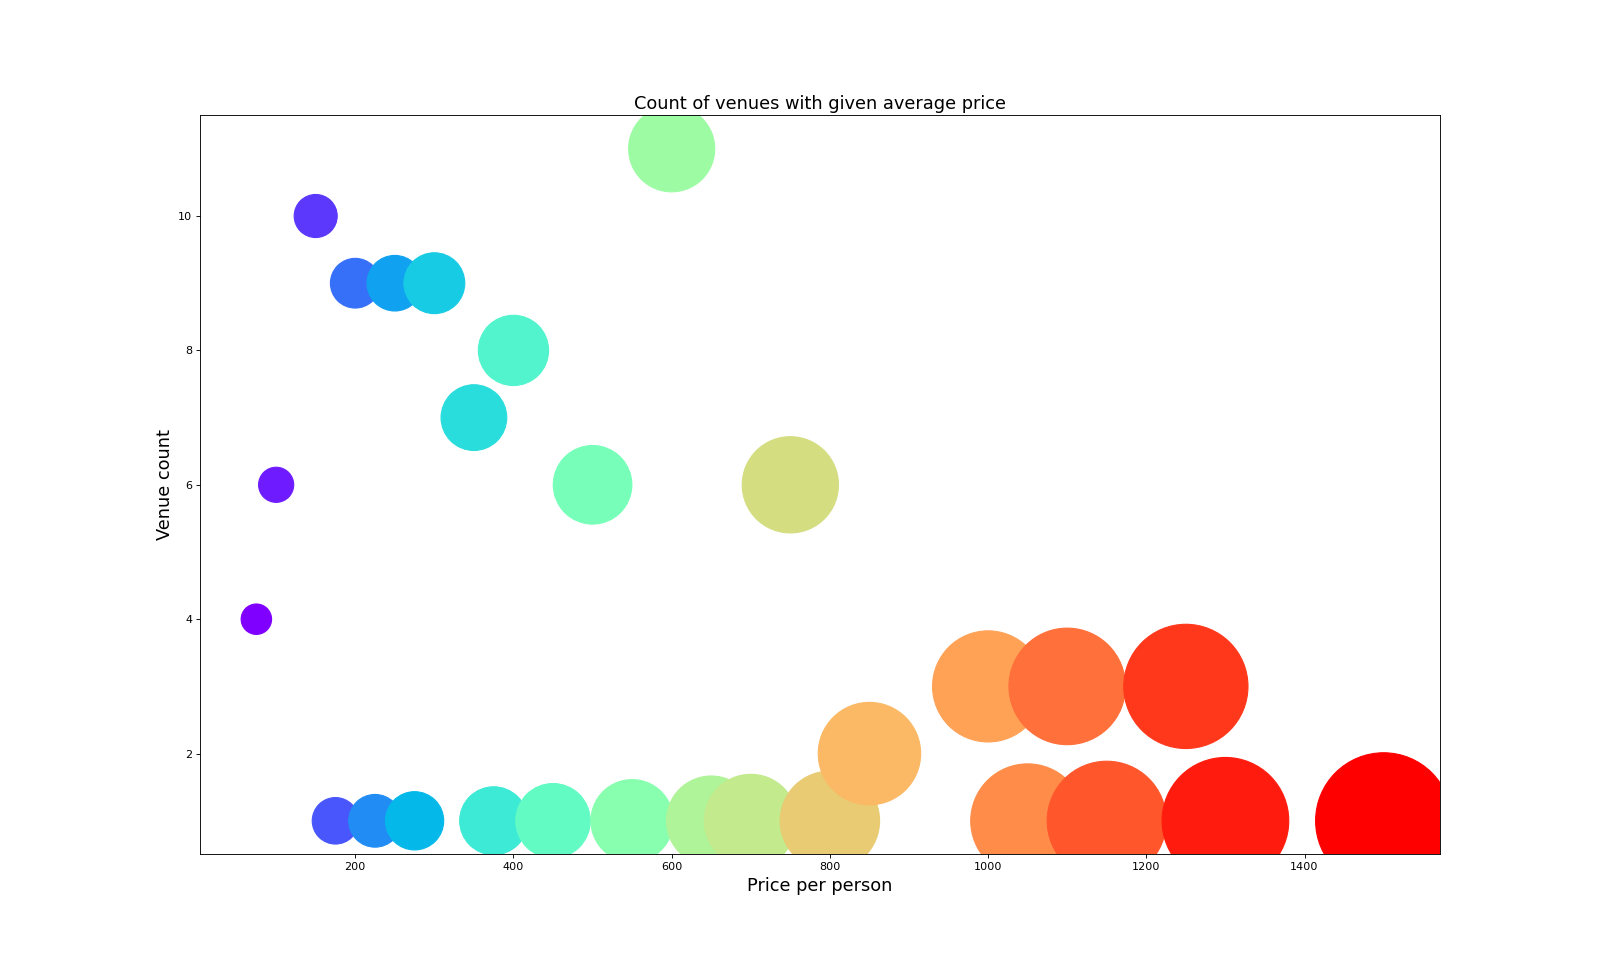

Text(0.5, 1.0, 'Count of venues with given average price')

In [25]:
#Avg cost vs venue
average_prices = venues_selected['average_price'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.scatter(average_prices.index, 
            average_prices.values, 
            s = average_prices.index*10, 
            c = cm.rainbow(np.linspace(0, 1, len(average_prices.index))))
plt.xlabel("Price per person", fontsize = 16)
plt.ylabel("Venue count", fontsize = 16)
plt.title("Count of venues with given average price", fontsize = 16)

Here we can see that a large number of venues have an average price between Rs 200 and Rs 400.


#Price per range vs venue
We will now  use the price_range column to plot the venues on a map. To represent the venues with lower price we will use green and move towards red as the price increases.

In [26]:
color_map = {'1.0': 'green', '2.0': 'darkgreen', '3.0': 'orange', '4.0': 'red'}

pune_map = folium.Map(location = [pune_LATITUDE, pune_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, price_range in zip(venues_selected['venue'], 
                                                           venues_selected['address'], 
                                                           venues_selected['latitude'], 
                                                           venues_selected['longitude'], 
                                                           venues_selected['price_range'].astype(str)):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[price_range]),
        popup = label).add_to(pune_map)  


pune_map


The venues near Erandwane Kothrud primarily lower priced.The venues near Bundgarden camp are very expesive .
While venues near deccan area are affordable mixed price range.

# cluster the areas based on the  various features of restaurants
All these venues based on their price range, location and more to identify similar venues and the relationship amongst them.

In [27]:
#we will cluster venues in two different groups
from sklearn.cluster import KMeans

NO_OF_CLUSTERS = 2

clustering = venues_selected.drop(['venue', 'address', 'rating_bin', 'categories'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
venues_selected.insert(0, 'cluster_labels', kMeans.labels_)
venues_selected.head()

,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Snack Place,Hotel Tilak,18.5096,73.8470,1.0,4.2,"1549, Indira Chambers, Opposite Maharashtra Ma...",175.0,Very good
1,0,Café,Cafe Goodluck,18.5174,73.8415,2.0,4.3,"759/75, Goodluck Chowk, Deccan Gymkhana, Pune",400.0,Very good
2,1,BBQ Joint,Barbeque Nation,18.5163,73.8424,3.0,4.3,"3rd Floor, R Deccan Mall, JM Road, Pune",850.0,Very good
3,0,Indian Restaurant,Roopali Restaurant,18.5195,73.8414,1.0,4.3,"1227, Opposite British Library, FC Road, Pune",200.0,Very good
4,0,Bistro,Le Plaisir,18.5143,73.8386,3.0,4.6,"Survey 759/125, Rajkamal, Opposite Kelkar Eye ...",500.0,Very good


In [28]:
pune_map = folium.Map(location = [pune_LATITUDE, pune_LONGITUDE], zoom_start = 13)
color_map = { 0: 'green', 1: 'red'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(venues_selected['venue'], 
                                                        venues_selected['address'], 
                                                        venues_selected['cluster_labels'], 
                                                        venues_selected['latitude'], 
                                                        venues_selected['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(pune_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(pune_map)

pune_map

In [29]:
result = venues_selected[venues_selected['cluster_labels'] == 0]
print("Cluster 0")
result.head(10).reset_index(drop = True)

Cluster 0


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Snack Place,Hotel Tilak,18.5096,73.8470,1.0,4.2,"1549, Indira Chambers, Opposite Maharashtra Ma...",175.0,Very good
1,0,Café,Cafe Goodluck,18.5174,73.8415,2.0,4.3,"759/75, Goodluck Chowk, Deccan Gymkhana, Pune",400.0,Very good
2,0,Indian Restaurant,Roopali Restaurant,18.5195,73.8414,1.0,4.3,"1227, Opposite British Library, FC Road, Pune",200.0,Very good
3,0,Bistro,Le Plaisir,18.5143,73.8386,3.0,4.6,"Survey 759/125, Rajkamal, Opposite Kelkar Eye ...",500.0,Very good
4,0,South Indian Restaurant,Vaishali,18.5210,73.8412,2.0,4.5,"1218/1, Rage Path, Ganeshwadi, Shivajinagar, F...",250.0,Very good
5,0,Vegetarian / Vegan Restaurant,Sukanta,18.5171,73.8443,2.0,4.4,"636, Pulachi Wadi, Deccan Gymkhana, Pune",350.0,Very good
6,0,Vegetarian / Vegan Restaurant,Wadeshwar,18.5187,73.8417,1.0,4.2,"Survey 1229/A, FC Road, Pune",200.0,Very good
7,0,Sandwich Place,Flavours Street,18.5190,73.8414,1.0,4.3,"Near British Library, FC Road, Pune",100.0,Very good
8,0,Fast Food Restaurant,Supreme Corner,18.5205,73.8461,1.0,4.3,"1206, Opposite Sambhaji Udyan, JM Road, Pune",150.0,Very good
9,0,Bakery,Kayani Bakery,18.5149,73.8798,1.0,4.6,"6, DEH, Koyani Road, Camp, East Street, Pune",75.0,Very good


In [30]:
print("These venues for cluster 0 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 0 have mean price range of 1.86 and rating spread around 3.97


In [31]:
result = venues_selected[venues_selected['cluster_labels'] == 1]
print("Cluster 1")
result.head(10).reset_index(drop = True)

Cluster 1


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,BBQ Joint,Barbeque Nation,18.5163,73.8424,3.0,4.3,"3rd Floor, R Deccan Mall, JM Road, Pune",850.0,Very good
1,1,Bar,1000 Oaks,18.5106,73.8799,3.0,4.2,"2417, Near HDFC Bank, East Street, Pune",750.0,Very good
2,1,Pub,Hidden Place - The Hangout,18.5366,73.8754,3.0,4.3,"33, 34 36, Ground Floor, Akshay Complex, Off B...",850.0,Very good
3,1,Hotel,Paasha - JW Marriott Pune,18.5322,73.8297,4.0,4.8,"Senapati Bapat Road, Pune",1250.0,Very good
4,1,Asian Restaurant,Spice Kitchen - JW Marriott Pune,18.5318,73.8297,4.0,4.3,"F.P. 403 A/1, Survey 985, Ground Floor, Senapa...",1100.0,Very good
5,1,Bakery,Spice Kitchen - JW Marriott Pune,18.5318,73.8297,4.0,4.3,"F.P. 403 A/1, Survey 985, Ground Floor, Senapa...",1100.0,Very good
6,1,Lounge,Evviva Sky Lounge - Crowne Plaza Pune City Centre,18.5312,73.8768,4.0,4.3,"CTS 37 & 37/1, 8th Floor, Crowne Plaza Pune Ci...",1150.0,Very good
7,1,Lounge,Paasha - JW Marriott Pune,18.5322,73.8297,4.0,4.8,"Senapati Bapat Road, Pune",1250.0,Very good
8,1,Italian Restaurant,Little Italy,18.5348,73.8382,3.0,4.4,"465, Ganeshkhind, Model Colony, Near Pune Cent...",750.0,Very good
9,1,Bistro,German Bakery Wunderbar,18.5200,73.8306,3.0,3.9,"153/A, Varun Complex, Near Demech House, Law C...",750.0,Good


In [32]:
print("These venues for cluster 1 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 1 have mean price range of 3.57 and rating spread around 4.12


# 6.Result-
Based on our analysis above, we can draw a number of conclusions that will be useful to aid any visitor visiting the city of Pune, India.
After collecting data from the Foursquare and Zomato APIs, we got a list of 212 different venues. However, not all venues from the two APIs were identical. Hence, we had to inspect their latitude and longitude values as well as names to combine them and remove all the outliers. This resulted in a total venue count of 109.
We identified that from the total set of venues, majority of them were indian restaurants and vegitarian/vegan restaurants.

Finally, through clusters we identified that there are many venues which are relatively lower priced but have an average rating of 3.97. On the other hand, there are few venues which are high priced and have average rating of  around 4.12.
A company can use this information to build up an online website/mobile application, to provide users with up to date information about various venues in the city based on the search criteria (name, rating and price).

# 7.Conclusion

The purpose of this project was to explore the places that a visitor visiting Pune could explore. The venues have been identified using Foursquare and zomato API and have been plotted on map
The map reveals that there are so many places where one can visit during his stay in Pune. Based on the visitors venue rating and price requirements, he/she can choose the places.